In [ ]:
import warnings
warnings.filterwarnings("ignore")

### 2. Create a Modular & Object-Oriented Python Solution:
 a. Follow Object-Oriented Programming principles to design your solution. Ensure your
solution is modular and reusable.
-  b. Class 1: DataLoader:
- - i.  Loads data from provided csv
- - ii.  Data cleaning & pre-processing: Identify and handle missing or inconsistent data.
Flag and filter out invalid sensor_value readings (e.g., negative values for
temperature or power consumption).
- - iii. Load the cleaned data into database

- - iv. Ensure the function(s) can handle potential errors (e.g., duplicate rows, missing
columns).


c. Class 2: DatabaseHandler: Handles database connection & loads clean data into
database.


In [ ]:
import pandas as pd
import sqlite3

class DataLoader:
    """
    class to load, clean, and preprocess data from a csv file.
    """
    def __init__(self, csv_path):
        """
        Initialize the DataLoader class with the path to the csv file.
        Args:
          csv_path (str): Path to the CSV file.
        """
        self.csv_path = csv_path
        self.data= None

    def load_csv(self):
        """
        Load data from the csv file into a pandas DataFrame.
        Raises:
        FileNotFoundError: If the csv file is not found.
        """

        try:
            self.data = pd.read_csv(self.csv_path)
            print("Data loaded successfully.")
        except FileNotFoundError as e:
             print(f" Error: {e}")
             raise

    def clean_data(self):
         """
         Clean and preprocess the data:
         - Drop rows with missing critical columns.
         - Remove invalid sensor_value readings (negative values).
         - Drop duplicate rows.
         """
         if self.data is None:
            raise ValueError("No data loaded. Please load the csv file first.")

         # Drop rows with missing critical columns
         critical_columns =['site_id', 'meter_id','timestamp', 'sensor_name', 'sensor_value','status']
         missing_columns = [ col for col in critical_columns if col not in self.data.columns]
         if missing_columns :
            raise ValueError(f"Missing critical columns: {missing_columns}")

         self.data.dropna(subset=critical_columns, inplace=True)

         # Remove invalid sensor_value readings (negative values)
         self.data= self.data[self.data['sensor_value'].apply(lambda x: isinstance(x,(int, float)) and x >=0)]

         # Remove duplicate rows
         self.data.drop_duplicates(inplace= True)

         # Handle the timestamp  columns
         self.data['timestamp'] = pd.to_datetime(self.data['timestamp'],errors ='coerce')
         self.data.dropna(subset=['timestamp'], inplace=True)
         print("Data cleaned successfully.")

    def get_clean_data(self):
      """
      Return the cleaned DataFrame.
      """
      if self.data is None:
         raise ValueError("Data not cleaned. Please clean the data first.")
      return self.data

    def save_cleaned_data(self, output_path):
      """
      save the cleaned data to a csv file.
      Args:
        output_path (str): Path where the cleaned csv will be saved.
      """
      if self.data is None:
         raise ValueError("Data not cleaned. Please clean the data first.")

      self.data.to_csv(output_path, index=False)
      print(f"Cleaned data saved to {output_path}")



# class 2: DatabaseHandler: Handles database connection & loads clean data into database.

class DatabaseHandler:
  """
  Class to handle database connections and  insert cleaned data into a SQLite database.
  """
  def __init__(self, db_path):
    """
    Initialize the DatabaseHandler class with the path.
    Args:
      db_path (str): Path to the SQLite database file.
    """
    self.db_path = db_path
    self.conn = None


  def connect(self):
    """
    Establish a connection to the SQLite database.
    """
    try:
      self.conn= sqlite3.connect(self.db_path)
      print("Connected to the database successfully.")

    except sqlite3.Error as e:
      print(f"Error connecting to the database: {e}")
      raise

  def create_tables(self):
     """
     Create necessary tables in the database.
     """
     if self.conn is None:
        raise ConnectionError("Database connection not established. Please connect to the database . you have to Call connect() first.")
     cursor= self.conn.cursor()

     # Create Sites table
     cursor.execute("""
          CREATE TABLE IF NOT EXISTS Sites (
             id INTEGER PRIMARY KEY AUTOINCREMENT,
             site_id TEXT UNIQUE NOT NULL
           )
        """)

       # Create Meters table
     cursor.execute("""
         CREATE TABLE IF NOT EXISTS Meters (
             id INTEGER PRIMARY KEY AUTOINCREMENT,
             meter_id TEXT UNIQUE NOT NULL,
             site_id TEXT NOT NULL,
             FOREIGN KEY (site_id) REFERENCES Sites(id)
           )

        """)

       # Create Sensors table
     cursor.execute("""
          CREATE TABLE IF NOT EXISTS Sensors (
              sensor_id INTEGER PRIMARY KEY AUTOINCREMENT,
              sensor_name TEXT UNIQUE NOT NULL
            )
         """)

        # Create Sensors table
     cursor.execute("""
           CREATE TABLE IF NOT EXISTS SensorReadings  (
                reading_id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp DATETIME NOT NULL,
                sensor_value REAL NOT NULL,
                meter_id INTEGER NOT NULL,
                sensor_id INTEGER NOT NULL,
                site_id INTEGER NOT NULL,
                status TEXT CHECK(status IN ('active', 'inactive', 'error')),
                FOREIGN KEY (meter_id) REFERENCES Meters (id),
                FOREIGN KEY (sensor_id) REFERENCES Sensors (sensor_id)
                FOREIGN KEY (site_id) REFERENCES Sites (id)
              )
        """)
     self.conn.commit()
     print("Tables created successfully.")

  def insert_data(self, data):
        """
        Insert cleaned data into the database.

        Args:
            data (DataFrame): Cleaned data to be inserted.
        """
        if self.conn is None:
            raise ConnectionError("No database connection. Call connect() first.")

        cursor = self.conn.cursor()

        try:
            # Insert sites
            site_records = data[['site_id']].drop_duplicates()

            # Check for existing site_id values in the database
            existing_sites_query = "SELECT site_id FROM Sites"
            cursor.execute(existing_sites_query)
            existing_site_ids = {row[0] for row in cursor.fetchall()}

            # Filter out already existing site_id values
            site_records = site_records[~site_records['site_id'].isin(existing_site_ids)]
            # Insert only new sites
            site_records.to_sql('Sites', self.conn, if_exists='append', index=False)


            # Insert meters
            meter_records = data[['meter_id', 'site_id']].drop_duplicates()

            # Check for existing meter_id values in the database
            existing_meters_query= "SELECT meter_id FROM Meters"
            cursor.execute(existing_meters_query)
            existing_meter_ids = {row[0] for row in cursor.fetchall()}

            # Filter out already existing meters_id values
            meter_records = meter_records[~meter_records['meter_id'].isin(existing_meter_ids)]
            # Insert only new meters
            meter_records.to_sql('Meters', self.conn, if_exists='append', index=False)


            # Insert sensors
            sensor_records = data[['sensor_name']].drop_duplicates()

            # Check for existing sensor_id values in the database
            existing_sensors_query = "SELECT sensor_name FROM Sensors"
            cursor.execute(existing_sensors_query)
            existing_sensor_ids = {row[0] for row in cursor.fetchall()}

            # Filter out already existing
            sensor_records = sensor_records[~sensor_records['sensor_name'].isin(existing_sensor_ids)]
            # Insert only new sensors
            sensor_records['sensor_name'] = sensor_records['sensor_name'].str.strip()  # Ensure no trailing/leading spaces
            sensor_records.to_sql('Sensors', self.conn, if_exists='append', index=False)

            # Map Sensor  names to sensor Ids .
            cursor.execute("SELECT sensor_id, sensor_name FROM Sensors")
            sensor_mapping = {row[1]: row[0] for row in cursor.fetchall()}

            data['sensor_id'] = data['sensor_name'].map(sensor_mapping)
            if data['sensor_id'].isnull().any():
                 raise ValueError("Unmapped sensor_name found in data.")

            # Map Meter names to  meter Ids
            cursor.execute("SELECT id, meter_id FROM Meters")
            meter_mapping = {row[1]: row[0] for row in cursor.fetchall()}

            data['meter_id'] = data['meter_id'].map(meter_mapping)
            if data['meter_id'].isnull().any():
                 raise ValueError("Unmapped meter_name found in data.")

            # Map Sites names to sites Ids
            cursor.execute("SELECT id, site_id FROM Sites")
            site_mapping = {row[1]: row[0] for row in cursor.fetchall()}

            data['site_id'] = data['site_id'].map(site_mapping)
            if data['site_id'].isnull().any():
                  raise ValueError("Unmapped site_name found in data.")

            # Insert sensor readings
            reading_records = data[['timestamp', 'sensor_value', 'meter_id','sensor_id','site_id','status']]
            reading_records.to_sql('SensorReadings', self.conn, if_exists='append', index=False)

            self.conn.commit()
            print("Data inserted successfully.")

        except sqlite3.Error as e:
            print(f"Error inserting data: {e}")
            raise


  def close_connection(self):
      """
      Close the database connection.
      """
      if self.conn:
        self.conn.close()
      print("Database connection closed.")


# Usage Example
if __name__ == "__main__":
  csv_path= '/content/IoT_Sensor_Data (1).csv'
  output_path = '/content/IoT_Sensor_Clean_Data.csv'
  db_path = '/content/IoT_Sensor_Data.db'



  # Load and clean data
  data_loader = DataLoader(csv_path)
  data_loader.load_csv()
  data_loader.clean_data()

  # Save the cleaned data
  data_loader.save_cleaned_data(output_path)

  # Get the cleaned DataFrame
  cleaned_data = data_loader.get_clean_data()

  # Handle database operations
  db_handler= DatabaseHandler(db_path)
  db_handler.connect()
  db_handler.create_tables()
  db_handler.insert_data(cleaned_data)
  db_handler.close_connection()




Data loaded successfully.
Data cleaned successfully.
Cleaned data saved to /content/IoT_Sensor_Clean_Data.csv
Connected to the database successfully.
Tables created successfully.
Data inserted successfully.
Database connection closed.


**d.** SQL Task: Write SQL queries (from within your Python script) to:
- i. Find the **total power consumption**  for each site over the two-week period.


In [ ]:
import sqlite3

def get_total_power_consumption_window(database_path, start_date, end_date):
    """
    Finds the total power consumption for each site over a two-week period using a window function.

    Parameters:
    - database_path: Path to the SQLite database.
    - start_date: Start date of the two-week period (YYYY-MM-DD format).
    - end_date: End date of the two-week period (YYYY-MM-DD format).
    """
    # Connect to the SQLite database
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()

    # SQL query using a window function with a join to fetch site name
    query = f"""
    SELECT DISTINCT
        s.id,
        s.site_id,
        SUM(CASE WHEN sr.sensor_id = 1 THEN sr.sensor_value ELSE 0 END) OVER (PARTITION BY sr.site_id) AS total_power_consumption
    FROM
        SensorReadings sr
    JOIN
        Sites s ON sr.site_id = s.id
    WHERE
        sr.timestamp BETWEEN '{start_date} 00:00:00' AND '{end_date} 23:59:59'
    """

    try:
        # Execute the query
        cursor.execute(query)
        results = cursor.fetchall()

        # Print the results
        print("Total Power Consumption for Each Site:")
        for row in results:
            print(f"Site Name: {row[1]}, Total Power Consumption: {row[2]:.2f}")

    except sqlite3.Error as e:
        print(f"An error occurred: {e}")

    finally:
        # Close the database connection
        conn.close()

# Example usage
database_path = "IoT_Sensor_Data.db"
start_date = "2023-12-01"  # Replace with your actual start date
end_date = "2023-12-14"    # Replace with your actual end date
get_total_power_consumption_window(database_path, start_date, end_date)


Total Power Consumption for Each Site:
Site Name: Site_A, Total Power Consumption: 225450.53
Site Name: Site_B, Total Power Consumption: 220911.02


- ii. Identify **meters contributing the highest power usage** at each site.

In [ ]:
import sqlite3

def get_highest_power_meters(database_path):
    """
    Identifies the meters contributing the highest power usage at each site.
    """

    # Connect to the SQLite database
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()

    # SQL query to identify highest power meters at each site (debugging version)
    query = f"""
    SELECT
        sr.meter_id,
        sr.site_id,
        m.meter_id AS meter_name,
        s.site_id AS site_name,
        SUM(CASE WHEN sr.sensor_id = 1 THEN sr.sensor_value ELSE 0 END) AS total_power_consumption
    FROM
        SensorReadings sr
    JOIN
        Meters m ON sr.meter_id = m.id
    JOIN
        Sites s ON sr.site_id = s.id
    WHERE
        sr.sensor_id = 1  -- Ensure we are only summing power consumption
    GROUP BY
        sr.meter_id, sr.site_id
    ORDER BY
        total_power_consumption DESC;
    """

    try:
        # Execute the query
        cursor.execute(query)
        results = cursor.fetchall()

        # Print the results
        print("Power Consumption Meters contributing the highest power usage at each site:")
        for row in results:
            print(f"Site Name: {row[3]}, Meter Name: {row[2]}, Total Power Consumption: {row[4]:.2f}")

    except sqlite3.Error as e:
        print(f"An error occurred: {e}")

    finally:
        # Close the database connection
        conn.close()

# Example usage
database_path = "IoT_Sensor_Data.db"
get_highest_power_meters(database_path)


Power Consumption Meters contributing the highest power usage at each site:
Site Name: Site_A, Meter Name: Site_A_Meter_1, Total Power Consumption: 76973.27
Site Name: Site_A, Meter Name: Site_A_Meter_2, Total Power Consumption: 74805.03
Site Name: Site_B, Meter Name: Site_B_Meter_1, Total Power Consumption: 74436.70
Site Name: Site_B, Meter Name: Site_B_Meter_3, Total Power Consumption: 73742.04
Site Name: Site_A, Meter Name: Site_A_Meter_3, Total Power Consumption: 73672.23
Site Name: Site_B, Meter Name: Site_B_Meter_2, Total Power Consumption: 72732.28


- iii dentify any missing timestamps in the data for each meter.

In [ ]:
import sqlite3
from datetime import datetime, timedelta

def find_missing_timestamps(database_path):
    """
    Identifies missing timestamps in the data for each meter and prints the missing timestamps.
    If there are no missing timestamps, prints a message indicating that.

    Parameters:
    - database_path: Path to the SQLite database.
    """
    # Connect to the SQLite database
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()

    # Get the first and last timestamp for each meter
    query = """
    SELECT meter_id, MIN(timestamp) AS first_timestamp, MAX(timestamp) AS last_timestamp
    FROM SensorReadings
    GROUP BY meter_id;
    """

    try:
        # Execute the query to get the first and last timestamp
        cursor.execute(query)
        meter_time_ranges = cursor.fetchall()

        print("Missing Timestamps for Each Meter:")
        missing_found = False  # Flag to track if any missing timestamps are found

        for meter_id, first_timestamp, last_timestamp in meter_time_ranges:
            # Convert to datetime objects for calculation
            first_time = datetime.strptime(first_timestamp, "%Y-%m-%d %H:%M:%S")
            last_time = datetime.strptime(last_timestamp, "%Y-%m-%d %H:%M:%S")

            # Generate the list of expected timestamps (assuming 5-minute intervals)
            current_time = first_time
            expected_timestamps = set()
            while current_time <= last_time:
                expected_timestamps.add(current_time.strftime("%Y-%m-%d %H:%M:%S"))
                current_time += timedelta(minutes=5)  # Adjust to 5-minute interval

            # Get all existing timestamps for the current meter
            cursor.execute("""
            SELECT timestamp
            FROM SensorReadings
            WHERE meter_id = ?
            """, (meter_id,))
            existing_timestamps = {row[0] for row in cursor.fetchall()}

            # Find missing timestamps
            missing_timestamps = expected_timestamps - existing_timestamps

            # If missing timestamps are found, print them
            if missing_timestamps:
                missing_found = True
                for missing_timestamp in sorted(missing_timestamps):
                    print(f"Meter ID: {meter_id}, Missing Timestamp: {missing_timestamp}")

        # If no missing timestamps are found, print a message
        if not missing_found:
            print("There are no missing timestamps for any meter.")

    except sqlite3.Error as e:
        print(f"An error occurred: {e}")

    finally:
        # Close the database connection
        conn.close()

# Example usage
database_path = "IoT_Sensor_Data.db"
find_missing_timestamps(database_path)


Missing Timestamps for Each Meter:
There are no missing timestamps for any meter.


**e. Class 2: DataPreProcessor: Processes data using Pandas and NumPy.**

- i.
Fetch data from the database using SQL and process it using Pandas.
- ii.Perform the following operations:
 - 1. Normalize the sensor values (e.g., scale power values between 0 and 1).
 - 2. Create a time-series DataFrame with timestamps as the index.
 - 3. Fill missing timestamps with appropriate interpolated values.

In [ ]:
import sqlite3
import pandas as pd
import numpy as np


def resample_group(group):
    """Resamples a group based on site_id, meter_id, and sensor_name.

    Args:
        group (DataFrame): Dataframe group to resample.

    Returns:
        DataFrame: Resampled dataframe.
    """
    # Resample only numeric columns (sensor_value)
    group_resampled = group[['sensor_value']].resample('5min').mean()

    # Fill non-numeric columns with the first occurrence (or mode if applicable)
    group_resampled['site_id'] = group['site_id'].iloc[0]
    group_resampled['meter_id'] = group['meter_id'].iloc[0]
    group_resampled['sensor_name'] = group['sensor_name'].iloc[0]

    return group_resampled


class DataPreProcessor:
    """Class for processing sensor data."""

    def __init__(self, database_path):
        """Initialize DataPreProcessor with the database path.

        Args:
            database_path (str): Path to the database.
        """
        self.database_path = database_path
        self.data = None

    def fetch_data(self):
        """Fetch data from the database using SQL."""
        try:
            # Connect to the SQLite database
            conn = sqlite3.connect(self.database_path)
            query = """
                SELECT
                    sr.timestamp,
                    sr.sensor_value,
                    sr.status,
                    m.meter_id,
                    s.sensor_name,
                    si.site_id
                FROM
                    SensorReadings sr
                JOIN
                    Meters m ON sr.meter_id = m.id
                JOIN
                    Sensors s ON sr.sensor_id = s.sensor_id
                JOIN
                    Sites si ON sr.site_id = si.id
            """
            self.data = pd.read_sql_query(query, conn)
            conn.close()
            print("Data fetched successfully.")

            # Print first 5 rows of fetched data for verification
            print("First 5 rows of fetched data:")
            print(self.data.head())

        except Exception as e:
            print(f"An error occurred while fetching data: {e}")

    def process(self):
        """Process the fetched data.

        1. Normalizes sensor values.
        2. Converts timestamps to a time-series index.
        3. Fills missing timestamps with interpolated values.
       """
        self.fetch_data()
        if self.data is None or self.data.empty:
            print("No data to process.")
            return

        # Normalize sensor values
        try:
            self.data['sensor_value'] = (self.data['sensor_value'] - self.data['sensor_value'].min()) / \
                                        (self.data['sensor_value'].max() - self.data['sensor_value'].min())
            print("Sensor values normalized successfully.")
        except Exception as e:
            print(f"An error occurred while normalizing sensor values: {e}")
            return

        # Convert timestamps and resample
        try:
            self.data['timestamp'] = pd.to_datetime(self.data['timestamp'])
            self.data.set_index('timestamp', inplace=True)

            # Group by site_id, meter_id, and sensor_name
            self.data = self.data.groupby(['site_id', 'meter_id', 'sensor_name']).apply(resample_group).reset_index(drop= True)

            # Interpolate missing sensor values
            self.data['sensor_value'] = self.data['sensor_value'].interpolate(method='linear')
            print("Missing timestamps filled successfully.")
        except Exception as e:
            print(f"An error occurred while processing data: {e}")

    def get_processed_data(self):
        """Return the processed data."""
        return self.data


# Example Usage
if __name__ == "__main__":
    # Define the path to your SQLite database
    database_path = "IoT_Sensor_Data.db"  # Ensure this is the correct database path

    # Create an instance of DataPreProcessor
    processor = DataPreProcessor(database_path)

    # Process the data
    processor.process()

    # Get and display the processed data
    processed_data = processor.get_processed_data()
    if processed_data is not None and not processed_data.empty:
        print("Processed Data:")
        print(processed_data.head())
    else:
        print("No processed data available.")


Data fetched successfully.
First 5 rows of fetched data:
             timestamp  sensor_value  status        meter_id  \
0  2023-12-01 00:00:00         67.53  active  Site_A_Meter_1   
1  2023-12-01 00:05:00         69.46   error  Site_A_Meter_1   
2  2023-12-01 00:10:00         65.72  active  Site_A_Meter_1   
3  2023-12-01 00:15:00         40.63   error  Site_A_Meter_1   
4  2023-12-01 00:20:00         26.25  active  Site_A_Meter_1   

         sensor_name site_id  
0  power_consumption  Site_A  
1           humidity  Site_A  
2  power_consumption  Site_A  
3  power_consumption  Site_A  
4  power_consumption  Site_A  
Sensor values normalized successfully.
Missing timestamps filled successfully.
Processed Data:
   sensor_value site_id        meter_id sensor_name
0      0.640706  Site_A  Site_A_Meter_1    humidity
1      0.640794  Site_A  Site_A_Meter_1    humidity
2      0.640882  Site_A  Site_A_Meter_1    humidity
3      0.640971  Site_A  Site_A_Meter_1    humidity
4      0.641059  

- f. Class 3: MetricsCalculator: Calculates metrics such as averages, maximums, and daily
sums and store them in relevant table

In [ ]:
import sqlite3
import pandas as pd

class MetricsCalculator:
    def __init__(self, database_path):
        self.database_path = database_path
        self.data = None

    def fetch_data(self):
        """Fetch data from the database using SQL."""
        try:
            conn = sqlite3.connect(self.database_path)
            query = """
                SELECT
                    sr.timestamp,
                    sr.sensor_value,
                    sr.status,
                    m.meter_id,
                    s.sensor_name,
                    si.site_id
                FROM
                    SensorReadings sr
                JOIN
                    Meters m ON sr.meter_id = m.id
                JOIN
                    Sensors s ON sr.sensor_id = s.sensor_id
                JOIN
                    Sites si ON sr.site_id = si.id
            """
            self.data = pd.read_sql_query(query, conn)
            conn.close()
            print("Data fetched successfully.")

            # Print sample of fetched data
            print("\nSample Data after Fetching:")
            print(self.data.head())  # Print first 5 rows for verification

        except Exception as e:
            print(f"An error occurred while fetching data: {e}")

    def calculate_metrics(self):
        """Calculate metrics: average, max, and daily sum."""
        if self.data is None or self.data.empty:
            print("No data to process.")
            return

        # Convert timestamp to datetime and set it as index
        self.data['timestamp'] = pd.to_datetime(self.data['timestamp'])
        self.data['date'] = self.data['timestamp'].dt.date  # Extract date

        # Group by site_id, meter_id, sensor_name, and date
        metrics = self.data.groupby(['site_id', 'meter_id', 'sensor_name', 'date']).agg(
            daily_avg=('sensor_value', 'mean'),
            daily_max=('sensor_value', 'max'),
            daily_sum=('sensor_value', 'sum')
        ).reset_index()

        print("Metrics calculated successfully.")

        # Print sample of calculated metrics
        print("\nSample Calculated Metrics:")
        print(metrics.head(10))  # Print first 10 rows for verification

        return metrics

    def store_metrics(self, metrics):
        """Store the calculated metrics into the database."""
        if metrics is None or metrics.empty:
            print("No metrics to store.")
            return

        try:
            conn = sqlite3.connect(self.database_path)
            cursor = conn.cursor()

            # Ensure the Metrics table exists
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS Metrics (
                    site_id INTEGER NOT NULL,
                    meter_id INTEGER NOT NULL,
                    sensor_name TEXT NOT NULL,
                    date DATE NOT NULL,
                    daily_avg REAL,
                    daily_max REAL,
                    daily_sum REAL,
                    PRIMARY KEY (site_id, meter_id, sensor_name, date)
                )
            """)

            # Insert each row in the metrics DataFrame
            for _, row in metrics.iterrows():
                cursor.execute("""
                    INSERT OR REPLACE INTO Metrics (site_id, meter_id, sensor_name, date, daily_avg, daily_max, daily_sum)
                    VALUES (?, ?, ?, ?, ?, ?, ?)
                """, (row['site_id'], row['meter_id'], row['sensor_name'], row['date'],
                      row['daily_avg'], row['daily_max'], row['daily_sum']))

            conn.commit()
            conn.close()
            print("Metrics stored successfully.")
        except Exception as e:
            print(f"An error occurred while storing metrics: {e}")

    def process_metrics(self):
        """Process data: fetch, calculate, and store metrics."""
        self.fetch_data()
        metrics = self.calculate_metrics()
        self.store_metrics(metrics)

# Example Usage:
if __name__ == "__main__":
    # Define the path to your SQLite database
    database_path = "IoT_Sensor_Data.db"

    # Create an instance of MetricsCalculator
    calculator = MetricsCalculator(database_path)

    # Process metrics (fetch, calculate, store)
    calculator.process_metrics()


Data fetched successfully.

Sample Data after Fetching:
             timestamp  sensor_value  status        meter_id  \
0  2023-12-01 00:00:00         67.53  active  Site_A_Meter_1   
1  2023-12-01 00:05:00         69.46   error  Site_A_Meter_1   
2  2023-12-01 00:10:00         65.72  active  Site_A_Meter_1   
3  2023-12-01 00:15:00         40.63   error  Site_A_Meter_1   
4  2023-12-01 00:20:00         26.25  active  Site_A_Meter_1   

         sensor_name site_id  
0  power_consumption  Site_A  
1           humidity  Site_A  
2  power_consumption  Site_A  
3  power_consumption  Site_A  
4  power_consumption  Site_A  
Metrics calculated successfully.

Sample Calculated Metrics:
  site_id        meter_id sensor_name        date  daily_avg  daily_max  \
0  Site_A  Site_A_Meter_1    humidity  2023-12-01  61.069894      99.68   
1  Site_A  Site_A_Meter_1    humidity  2023-12-02  58.916022      98.91   
2  Site_A  Site_A_Meter_1    humidity  2023-12-03  58.268478      97.88   
3  Site_A  S

g.  Class 4: GraphGenerator: Generate relevant plots/visualizations from the metrics data
and store them as PNGs

Metrics data fetched successfully.

Sample Data:
  site_id        meter_id sensor_name       date  daily_avg  daily_max  \
0  Site_A  Site_A_Meter_1    humidity 2023-12-01  61.069894      99.68   
1  Site_A  Site_A_Meter_1    humidity 2023-12-02  58.916022      98.91   
2  Site_A  Site_A_Meter_1    humidity 2023-12-03  58.268478      97.88   
3  Site_A  Site_A_Meter_1    humidity 2023-12-04  57.106408      98.85   
4  Site_A  Site_A_Meter_1    humidity 2023-12-05  63.076701      99.84   

   daily_sum  
0    5740.57  
1    5479.19  
2    5360.70  
3    5881.96  
4    6118.44  


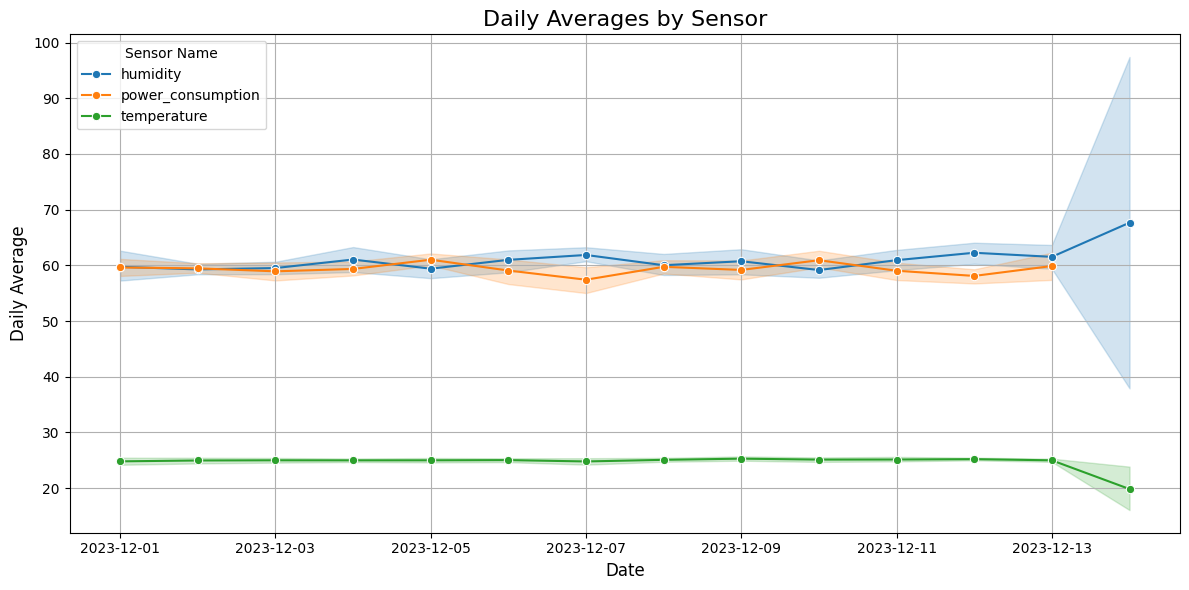

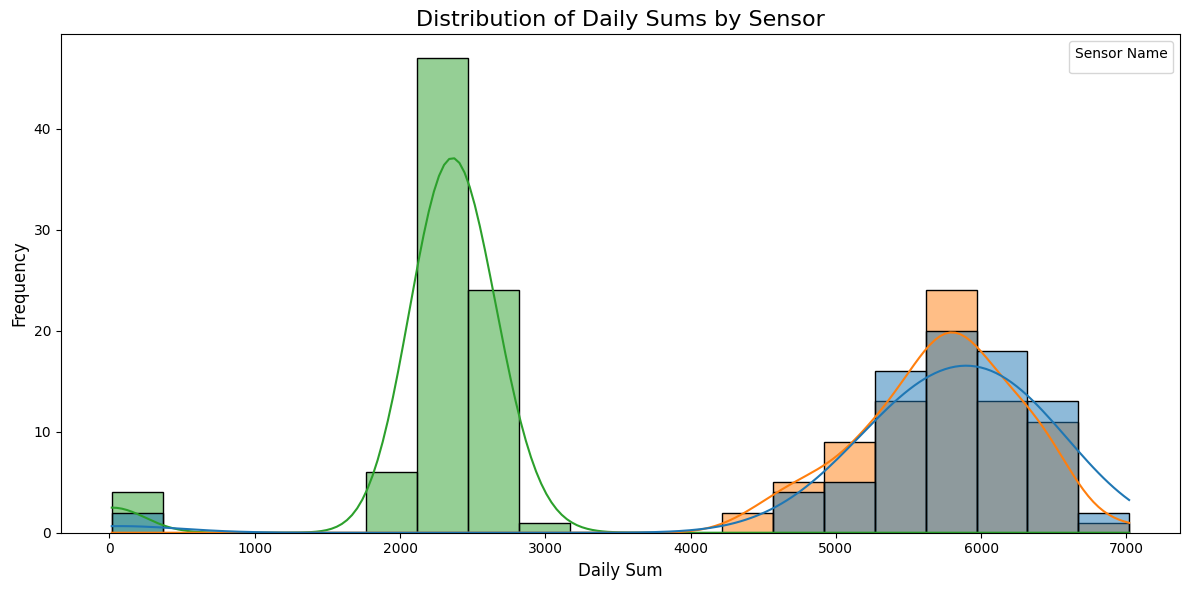

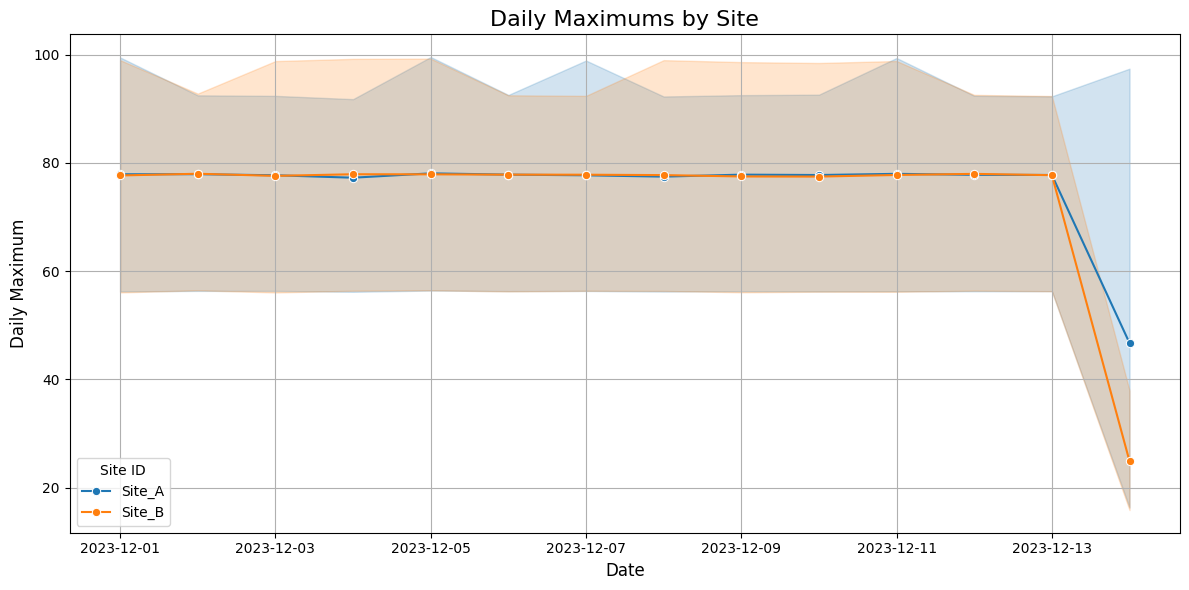

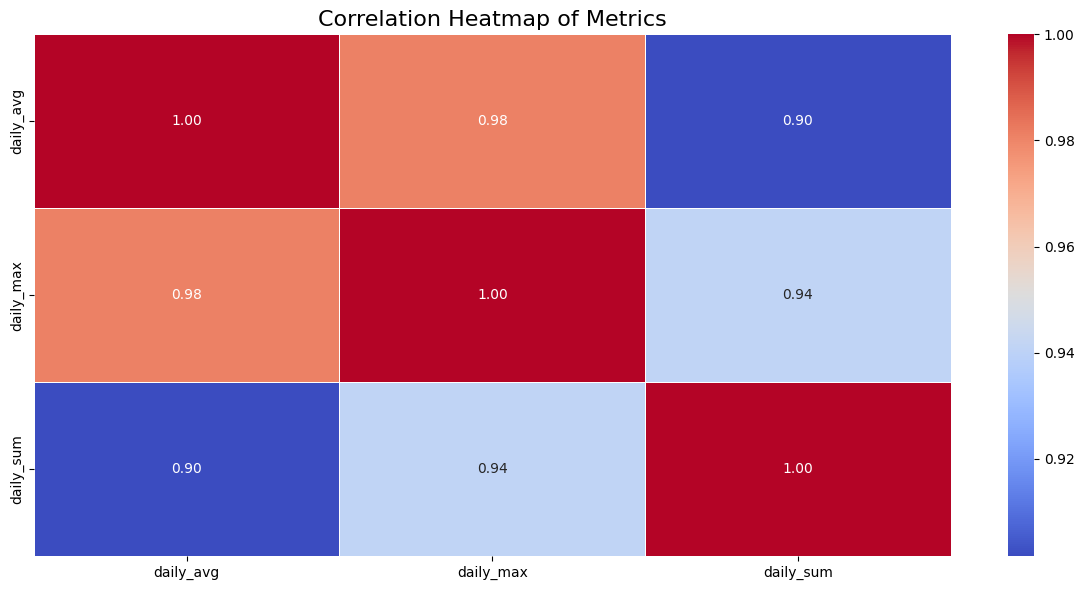

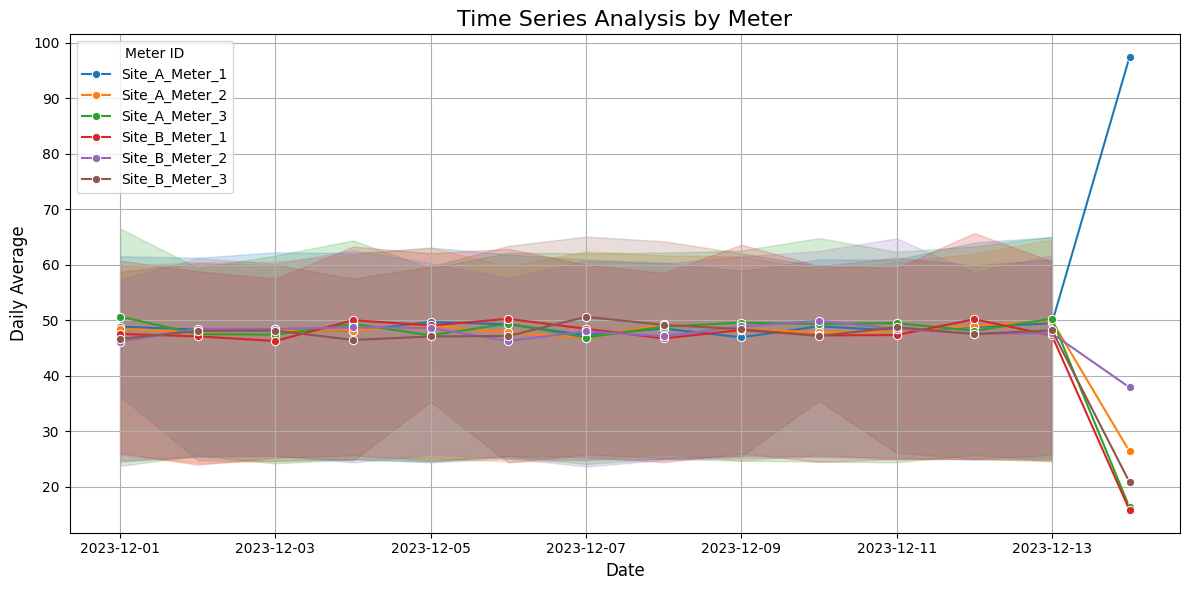

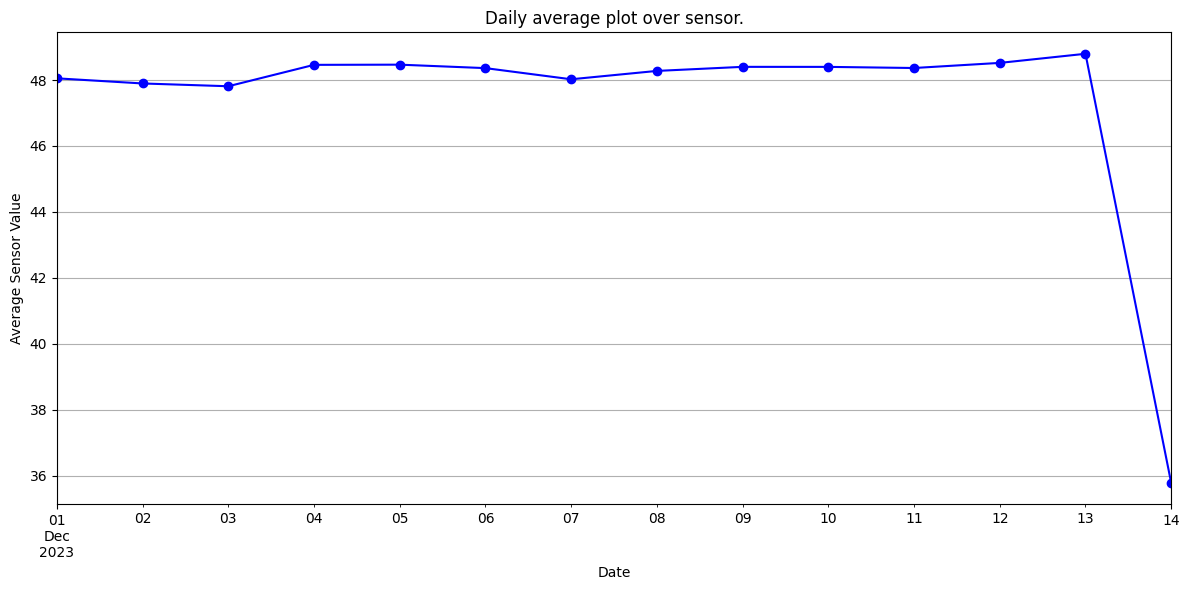

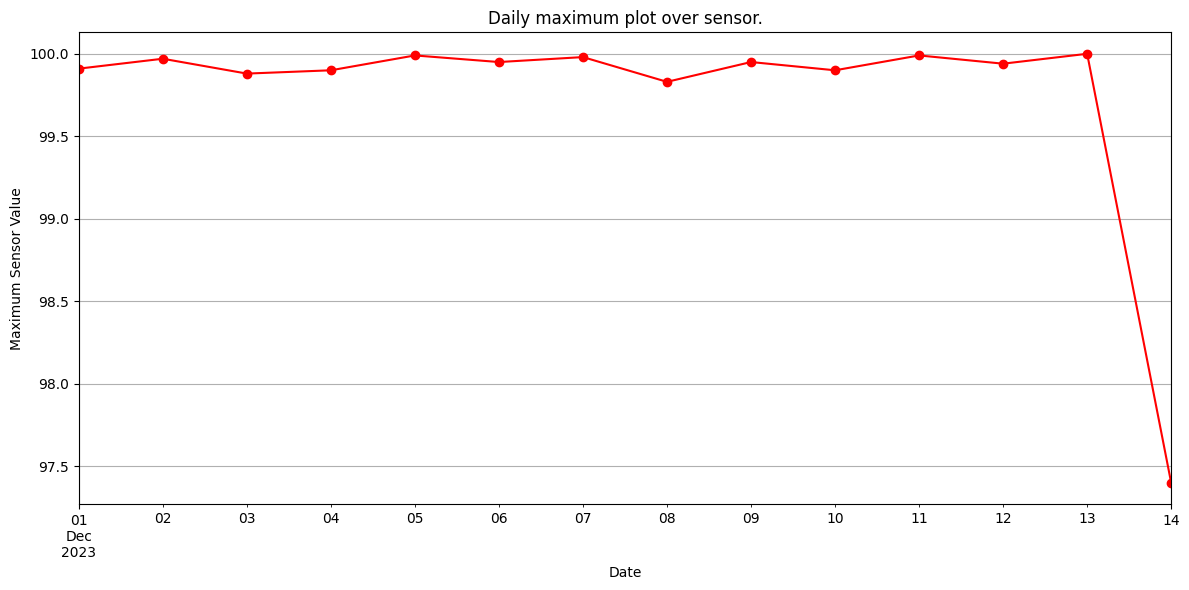

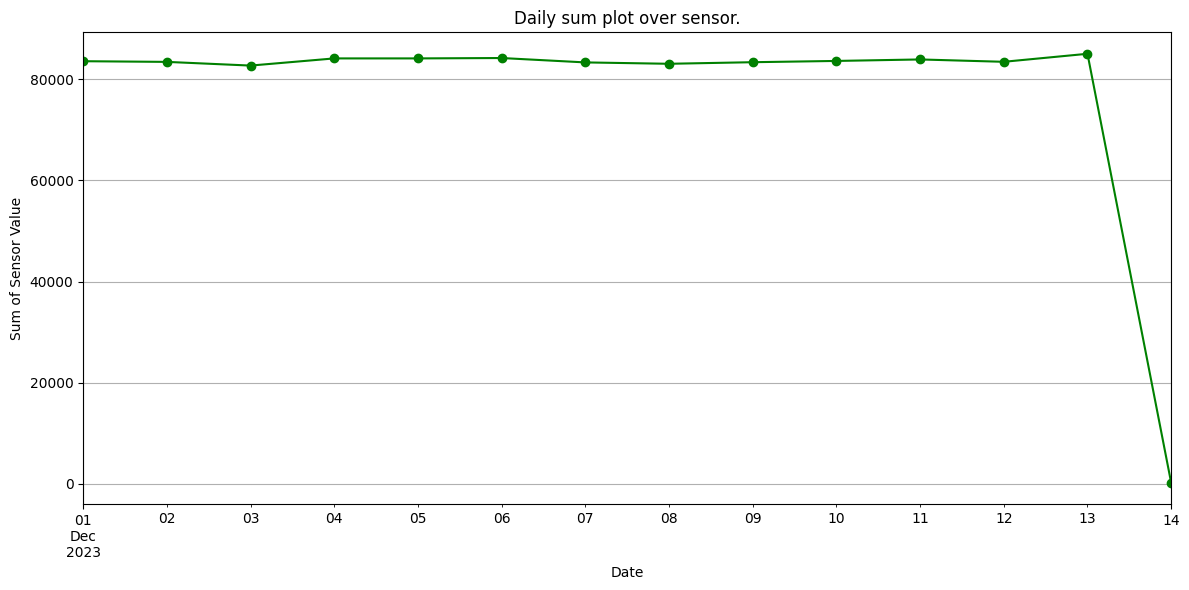

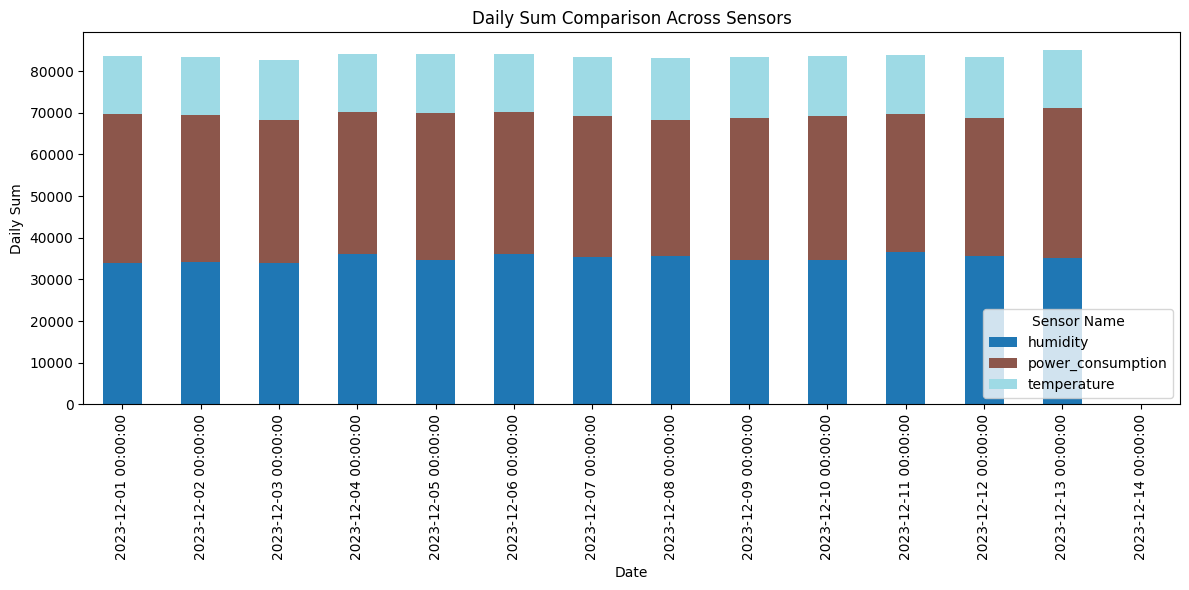

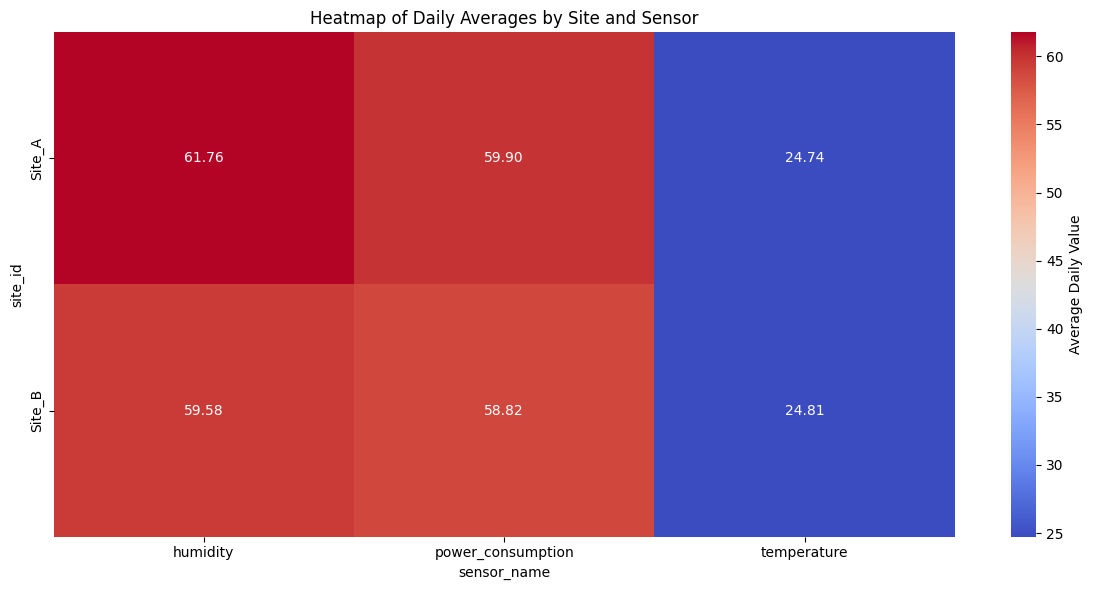

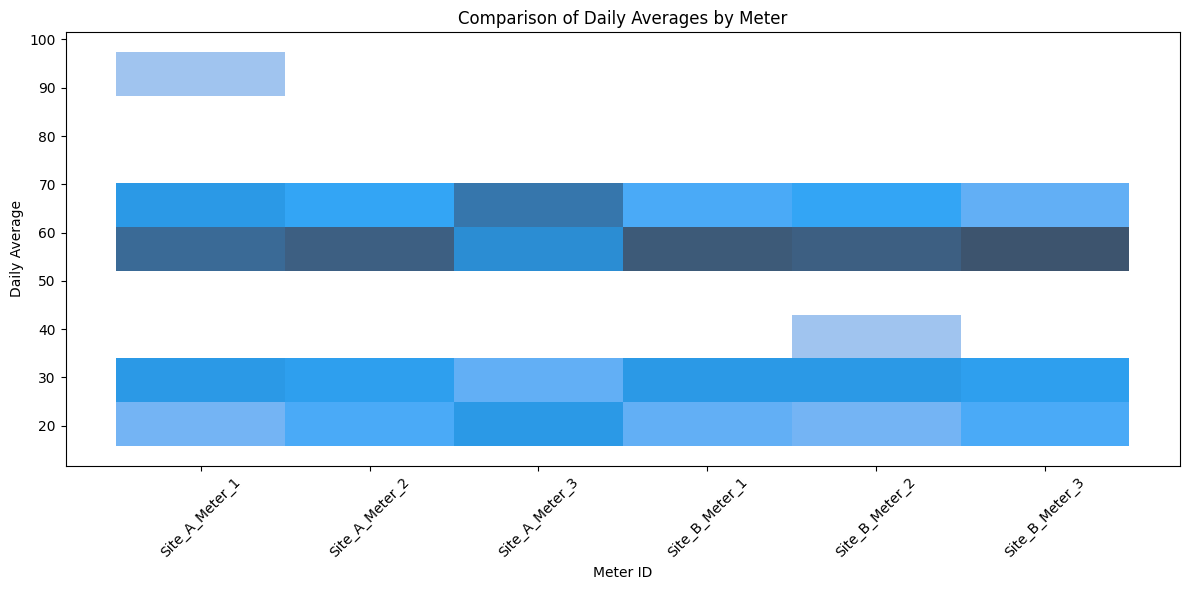

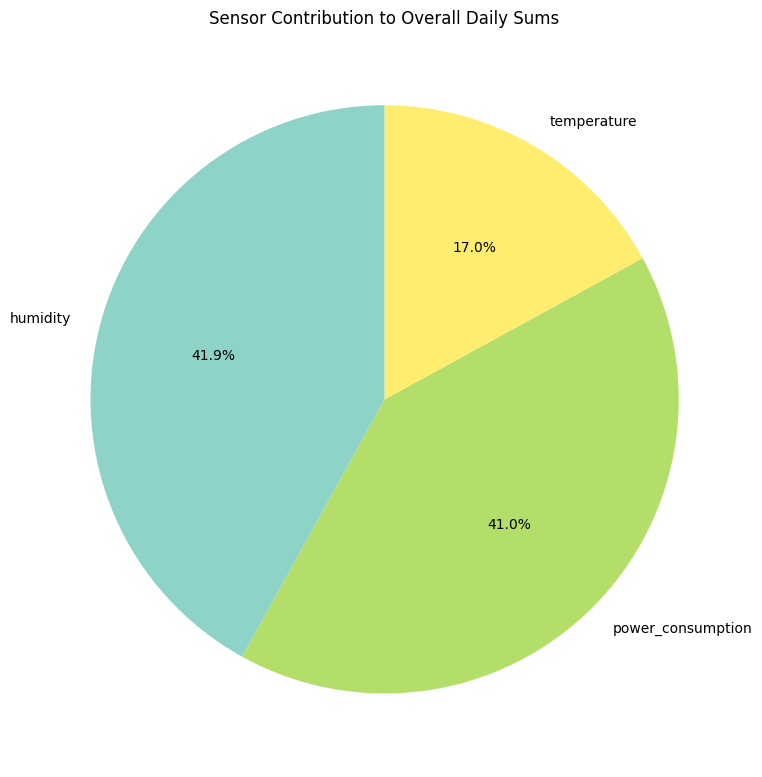

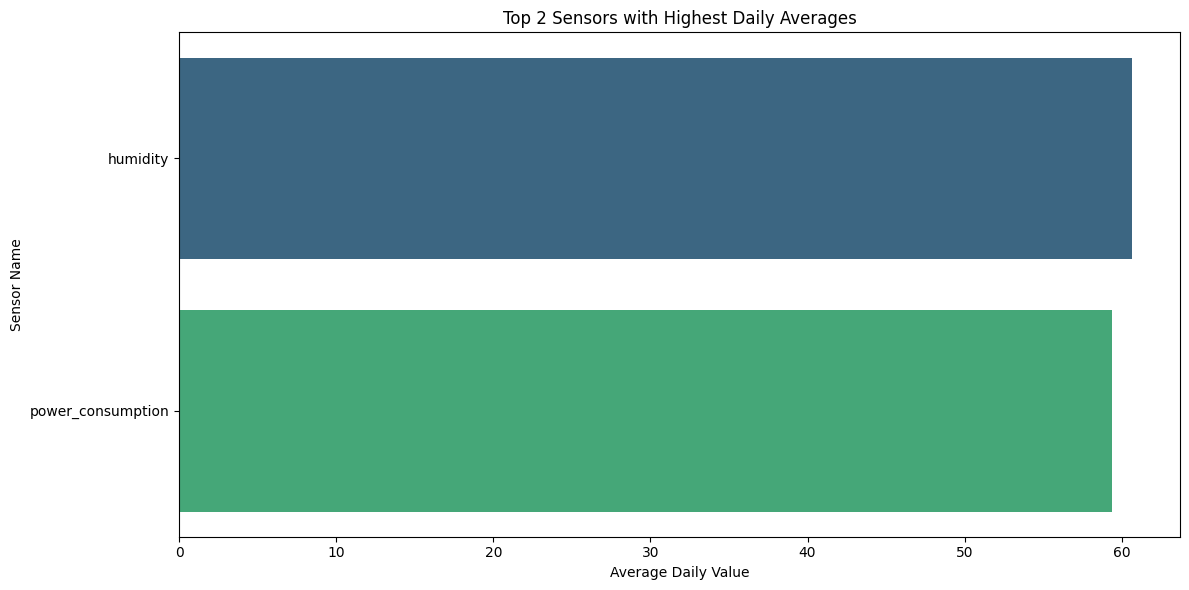

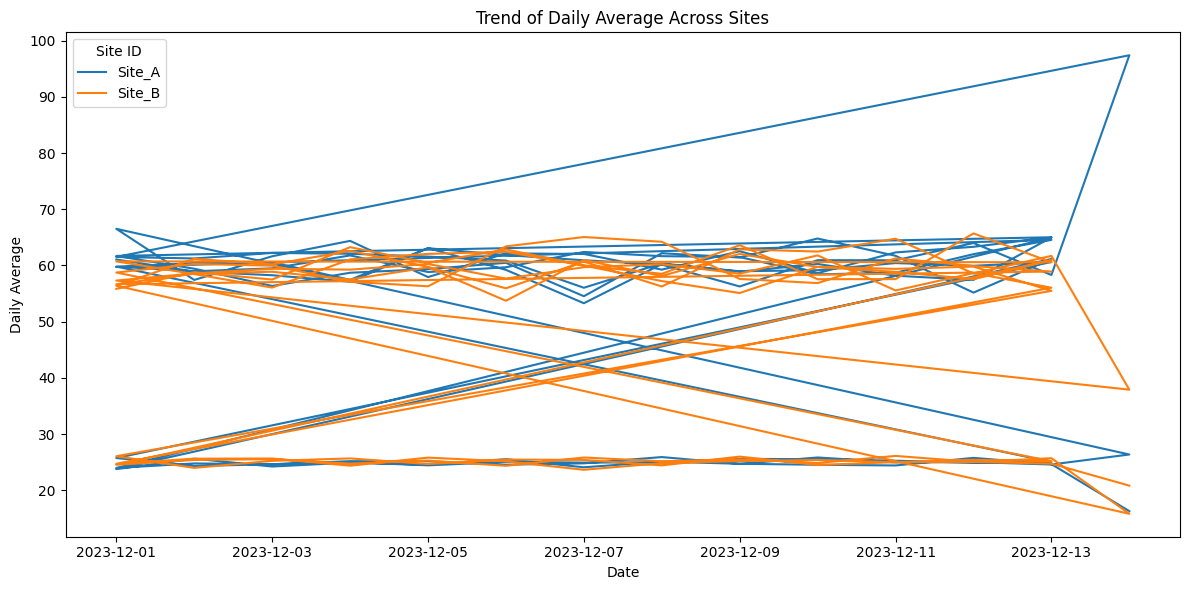

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class GraphGenerator:
    def __init__(self, database_path):
        self.database_path = database_path
        self.metrics_data = None

    def fetch_metrics_data(self):
        """Fetch metrics data from the database."""
        try:
            conn = sqlite3.connect(self.database_path)
            query = """
                SELECT site_id, meter_id, sensor_name, date, daily_avg, daily_max, daily_sum
                FROM Metrics
            """
            self.metrics_data = pd.read_sql_query(query, conn)
            conn.close()

            # Convert date column to datetime for plotting purposes
            self.metrics_data['date'] = pd.to_datetime(self.metrics_data['date'])

            print("Metrics data fetched successfully.")
            print("\nSample Data:")
            print(self.metrics_data.head())
        except Exception as e:
            print(f"An error occurred while fetching metrics data: {e}")

    def plot_daily_averages_by_sensor(self):
        """Line plot for daily averages by sensor."""
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=self.metrics_data,
            x="date",
            y="daily_avg",
            hue="sensor_name",
            marker="o"
        )
        plt.title("Daily Averages by Sensor", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Daily Average", fontsize=12)
        plt.legend(title="Sensor Name")
        plt.grid()
        plt.tight_layout()
        plt.savefig("daily_averages_by_sensor.png")
        plt.show()

    def plot_daily_maximums_by_site(self):
        """Line plot for daily maximums by site."""
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=self.metrics_data,
            x="date",
            y="daily_max",
            hue="site_id",
            marker="o"
        )
        plt.title("Daily Maximums by Site", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Daily Maximum", fontsize=12)
        plt.legend(title="Site ID")
        plt.grid()
        plt.tight_layout()
        plt.savefig("daily_maximums_by_site.png")
        plt.show()

    def plot_daily_sums_distribution(self):
        """Histogram for daily sums distribution."""
        plt.figure(figsize=(12, 6))
        sns.histplot(
            data=self.metrics_data,
            x="daily_sum",
            hue="sensor_name",
            kde=True,
            bins=20
        )
        plt.title("Distribution of Daily Sums by Sensor", fontsize=16)
        plt.xlabel("Daily Sum", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.legend(title="Sensor Name")
        plt.tight_layout()
        plt.savefig("daily_sums_distribution.png")
        plt.show()

    def generate_daily_avg_plot(self):
        """Generate plot for daily average sensor values."""
        plt.figure(figsize=(12, 6))
        avg_plot = self.metrics_data.groupby('date')['daily_avg'].mean()
        avg_plot.plot(kind='line', marker='o', color='b', title="Daily Average Sensor Value")
        plt.xlabel('Date')
        plt.ylabel('Average Sensor Value')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('daily_avg_plot.png')  # Save plot as PNG
       # plt.show()
        plt.title("Daily average plot over sensor.")

    def generate_daily_max_plot(self):
        """Generate plot for daily maximum sensor values."""
        plt.figure(figsize=(12, 6))
        max_plot = self.metrics_data.groupby('date')['daily_max'].max()
        max_plot.plot(kind='line', marker='o', color='r', title="Daily Maximum Sensor Value")
        plt.xlabel('Date')
        plt.ylabel('Maximum Sensor Value')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('daily_max_plot.png')  # Save plot as PNG
       # plt.show()
        plt.title("Daily maximum plot over sensor.")

    def generate_daily_sum_plot(self):
        """Generate plot for daily sum of sensor values."""
        plt.figure(figsize=(12, 6))
        sum_plot = self.metrics_data.groupby('date')['daily_sum'].sum()
        sum_plot.plot(kind='line', marker='o', color='g', title="Daily Sum of Sensor Values")
        plt.xlabel('Date')
        plt.ylabel('Sum of Sensor Value')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('daily_sum_plot.png')  # Save plot as PNG
       # plt.show()
        plt.title("Daily sum plot over sensor.")

    def plot_correlation_heatmap(self):
        """Heatmap for correlation between metrics."""
        plt.figure(figsize=(12, 6))
        correlation = self.metrics_data[["daily_avg", "daily_max", "daily_sum"]].corr()
        sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
        plt.title("Correlation Heatmap of Metrics", fontsize=16)
        plt.tight_layout()
        plt.savefig("correlation_heatmap.png")
        plt.show()

    def plot_time_series_by_meter(self):
        """Line plot for daily averages over time by meter."""
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=self.metrics_data,
            x="date",
            y="daily_avg",
            hue="meter_id",
            marker="o"
        )
        plt.title("Time Series Analysis by Meter", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Daily Average", fontsize=12)
        plt.legend(title="Meter ID")
        plt.grid()
        plt.tight_layout()
        plt.savefig("time_series_by_meter.png")
        plt.show()

    def plot_trend_of_metrics_across_sites(self):
        """Line plot: Trend of daily_avg across sites over time."""
        plt.figure(figsize=(12, 6))
        for site in self.metrics_data['site_id'].unique():
            site_data = self.metrics_data[self.metrics_data['site_id'] == site]
            plt.plot(site_data['date'], site_data['daily_avg'], label=site)
        plt.title("Trend of Daily Average Across Sites")
        plt.xlabel("Date")
        plt.ylabel("Daily Average")
        plt.legend(title="Site ID")
        plt.tight_layout()
        plt.savefig("trend_of_metrics_across_sites.png")
        plt.show()

    def plot_top_sensors_with_highest_daily_averages(self, top_n=2):
        """Bar plot: Top N sensors with highest daily averages."""
        sensor_avg = self.metrics_data.groupby('sensor_name')['daily_avg'].mean().sort_values(ascending=False).head(top_n)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=sensor_avg.values, y=sensor_avg.index, palette="viridis")
        plt.title(f"Top {top_n} Sensors with Highest Daily Averages")
        plt.xlabel("Average Daily Value")
        plt.ylabel("Sensor Name")
        plt.tight_layout()
        plt.savefig("top_sensors_with_highest_daily_averages.png")
        plt.show()

    def plot_sensor_contribution_pie_chart(self):
        """Pie chart: Contribution of sensors to overall daily sums."""
        sensor_contributions = self.metrics_data.groupby('sensor_name')['daily_sum'].sum()
        plt.figure(figsize=(8, 8))
        sensor_contributions.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3')
        plt.title("Sensor Contribution to Overall Daily Sums")
        plt.ylabel("")
        plt.tight_layout()
        plt.savefig("sensor_contribution_pie_chart.png")
        plt.show()

    def plot_comparison_of_metrics_by_meter(self):
        """Box plot: Comparison of metrics by meter."""
        plt.figure(figsize=(12, 6))
        sns.histplot(x='meter_id', y='daily_avg', data=self.metrics_data, palette="muted")
        plt.title("Comparison of Daily Averages by Meter")
        plt.xlabel("Meter ID")
        plt.ylabel("Daily Average")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("comparison_of_metrics_by_meter.png")
        plt.show()

    def plot_heatmap_of_metric_averages(self):
        """Heatmap: Average daily values by site and sensor."""
        heatmap_data = self.metrics_data.pivot_table(
            values='daily_avg', index='site_id', columns='sensor_name', aggfunc='mean')
        plt.figure(figsize=(12, 6))
        sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Average Daily Value'})
        plt.title("Heatmap of Daily Averages by Site and Sensor")
        plt.tight_layout()
        plt.savefig("heatmap_of_metric_averages.png")
        plt.show()

    def plot_daily_sum_comparison_across_sensors(self):
        """Stacked bar chart: Comparison of daily sums by date and sensor."""
        sum_data = self.metrics_data.groupby(['date', 'sensor_name'])['daily_sum'].sum().unstack()
        sum_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
        plt.title("Daily Sum Comparison Across Sensors")
        plt.xlabel("Date")
        plt.ylabel("Daily Sum")
        plt.legend(title="Sensor Name")
        plt.tight_layout()
        plt.savefig("daily_sum_comparison_across_sensors.png")
        plt.show()


    def generate_all_plots(self):
        """Generate all plots."""
        self.plot_daily_averages_by_sensor()
        self.plot_daily_sums_distribution()
        self.plot_daily_maximums_by_site()
        self.plot_correlation_heatmap()
        self.plot_time_series_by_meter()
        self.generate_daily_avg_plot()
        self.generate_daily_max_plot()
        self.generate_daily_sum_plot()
        self.plot_daily_sum_comparison_across_sensors()
        self.plot_heatmap_of_metric_averages()
        self.plot_comparison_of_metrics_by_meter()
        self.plot_sensor_contribution_pie_chart()
        self.plot_top_sensors_with_highest_daily_averages()
        self.plot_trend_of_metrics_across_sites()


# Example Usage:
if __name__ == "__main__":
    # Define the path to your SQLite database
    database_path = "IoT_Sensor_Data.db"

    # Create an instance of GraphGenerator
    generator = GraphGenerator(database_path)

    # Fetch metrics data
    generator.fetch_metrics_data()

    # Generate all plots
    generator.generate_all_plots()


- h. Class 5: DataReportGenerator: Calculated Metrics be exported into CSV

In [ ]:
import sqlite3
import pandas as pd

class DataReportGenerator:
    def __init__(self, database_path):
        self.database_path = database_path

    def fetch_metrics(self):
        """Fetch the calculated metrics from the database."""
        try:
            conn = sqlite3.connect(self.database_path)
            query = "SELECT * FROM Metrics"  # Assuming the table with calculated metrics is named 'Metrics'
            metrics_data = pd.read_sql_query(query, conn)
            conn.close()
            print("Metrics data fetched successfully.")

            # Print sample of fetched data
            print("\nSample Data after Fetching Metrics:")
            print(metrics_data.head())  # Print first 5 rows for verification

            return metrics_data
        except Exception as e:
            print(f"An error occurred while fetching metrics: {e}")
            return None

    def generate_report(self, metrics_data):
        """Generate a CSV report from the fetched metrics data."""
        if metrics_data is None or metrics_data.empty:
            print("No data to generate report.")
            return

        try:
            # Export the metrics data to a CSV file
            metrics_data.to_csv('metrics_report.csv', index=False)
            print("Report generated and saved as 'metrics_report.csv'.")
        except Exception as e:
            print(f"An error occurred while generating the report: {e}")
if __name__ == "__main__":
    # Define the path to your SQLite database
    database_path = "IoT_Sensor_Data.db"

    # Create an instance of DataReportGenerator
    report_generator = DataReportGenerator(database_path)

    # Fetch the stored metrics data and generate the report
    metrics_data = report_generator.fetch_metrics()
    report_generator.generate_report(metrics_data)



Metrics data fetched successfully.

Sample Data after Fetching Metrics:
  site_id        meter_id sensor_name        date  daily_avg  daily_max  \
0  Site_A  Site_A_Meter_1    humidity  2023-12-01  61.069894      99.68   
1  Site_A  Site_A_Meter_1    humidity  2023-12-02  58.916022      98.91   
2  Site_A  Site_A_Meter_1    humidity  2023-12-03  58.268478      97.88   
3  Site_A  Site_A_Meter_1    humidity  2023-12-04  57.106408      98.85   
4  Site_A  Site_A_Meter_1    humidity  2023-12-05  63.076701      99.84   

   daily_sum  
0    5740.57  
1    5479.19  
2    5360.70  
3    5881.96  
4    6118.44  
Report generated and saved as 'metrics_report.csv'.
